# Sentiment Analysis on mobile phone reviews

The given task is to learn sentiment from all the given reviews and predict rating from a new review. This objective is attained by following the steps listed below:

### Importing the modules

In [1]:
# !conda install -c ulmo urllib3

In [2]:
import pandas as pd
import numpy as np
import nltk
import future
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression


from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn import metrics


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import urllib3.request  # for Python 3: from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords 


import pickle as pkl
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from datetime import datetime

/home/curiousgirl/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### Data Labeling

- In this step we clean the data and label the data as <br>
  > 0 for Negative <br>
  > 1 for Neutral <br>
  > 2 for Positive
- Read the data from __'Amazon_Unlocked_Mobile.csv'__ and add new column for labels

In [3]:
def label_data():
    rows = pd.read_csv('Amazon_Unlocked_Mobile.csv', header=0, index_col=False, delimiter=',')
    labels = []
    for cell in rows['Rating']:
        if cell >= 4:
            labels.append('2')   #Positive
        elif cell == 3:
            labels.append('1')   #Neutral
        else:
            labels.append('0')   #Negative
            
    rows['Label'] = labels
    del rows['Review Votes']
    return rows

### Data Cleaning

Remove all the rows containing blank cells. The resultant data is stored as __'labelled_dataset.csv'__

In [4]:
def clean_data(data):
    #columnwise print number of rows containing blank values
    #print data.isnull().sum()
    
    #replace blank values in all the cells with 'nan'
    data.replace('',np.nan,inplace=True)
    #delete all the rows which contain at least one cell with nan value
    data.dropna(axis=0, how='any', inplace=True)
    
    #Check the number of rows containing blank values. This should be zero now as compared to first line of this function
    #print data.isnull().sum()
    #save output csv file
    data.to_csv('labelled_dataset.csv', index=False)
    return data

### Data preprocessing

The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.

- remove html tags using BeautifulSoup
- remove non-character such as digits and symbols
- convert to lower case
- remove stop words such as "the" and "and" if needed
- convert to root words by stemming if needed

In [5]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [6]:
# def modelEvaluation(predictions, y_test_set):
#     #Print model evaluation to predicted result 
    
#     print("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))
#     print("\nAUC score : {:.4f}".format(roc_auc_score(y_test_set, predictions)))
#     print("\nClassification report : \n", metrics.classification_report(y_test_set, predictions))
#     print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test_set, predictions))

### Bag of Words

The sentiment analysis of given text can be done in two ways. First, we need to find a word embedding to convert a text into a numerical representation. Second, we fit the numerical representations of text to machine learning algorithms or deep learning architectures.

One common approach of word embedding is frequency based embedding such as Bag of Words (BoW) model. BoW model learns a vocubulary list from a given corpus and represents each document based on some counting methods of words. In this part, we will explore the model performance of using BoW with supervised learning algorithms. Here's the workflow in this part.

- Step 1 : Preprocess raw reviews to cleaned reviews
- Step 2 : Create BoW using CountVectorizer / Tfidfvectorizer in sklearn
- Step 3 : Transform review text to numerical representations (feature vectors)
- Step 4 : Fit feature vectors to supervised learning algorithm (eg. Naive Bayes, Logistic regression, etc.)
- Step 5 : Improve the model performance by GridSearch

In [7]:
if __name__ == '__main__':
    data = label_data()
    data = clean_data(data)
    #prints first 5 rows of the dataset
    print(data.head())

                                        Product Name Brand Name   Price  \
0  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   

   Rating                                            Reviews Label  
0       5  I feel so LUCKY to have found this used (phone...     2  
1       4  nice phone, nice up grade from my pantach revu...     2  
2       5                                       Very pleased     2  
3       4  It works good but it goes slow sometimes but i...     2  
4       4  Great phone to replace my lost phone. The only...     2  


### Visualisation

Text(0, 0.5, 'Count')

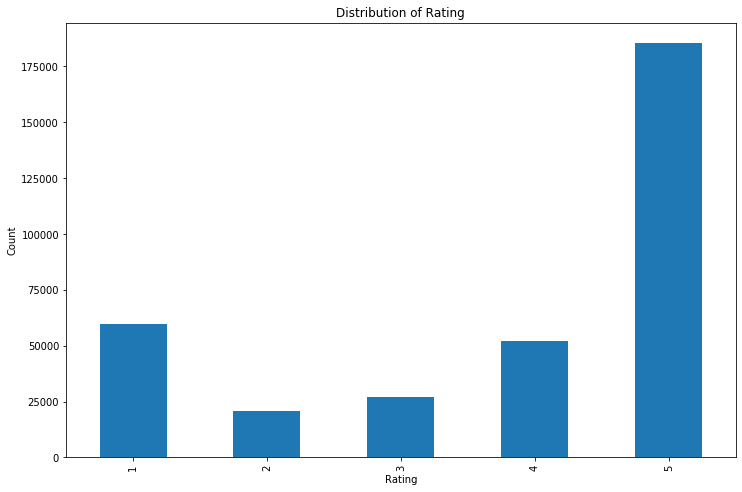

In [8]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(data['Rating'])
data['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 20 Brands')

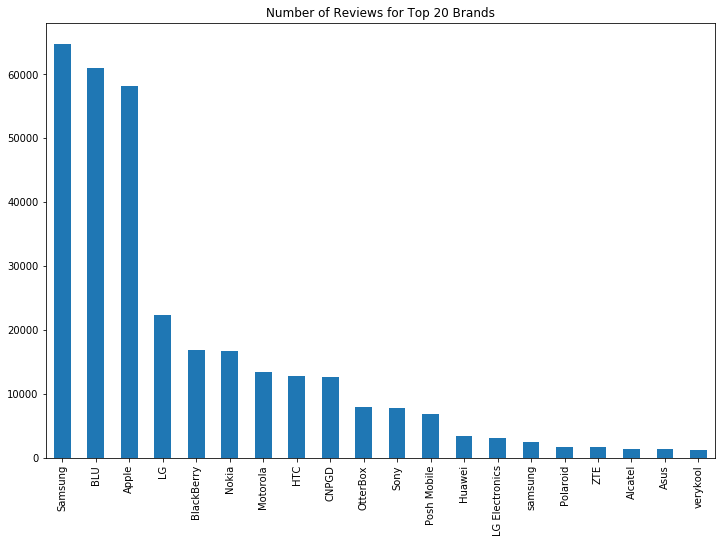

In [9]:
# Plot number of reviews for top 20 brands
brands = data["Brand Name"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")

Text(0.5, 1.0, 'Number of Reviews for Top 50 Products')

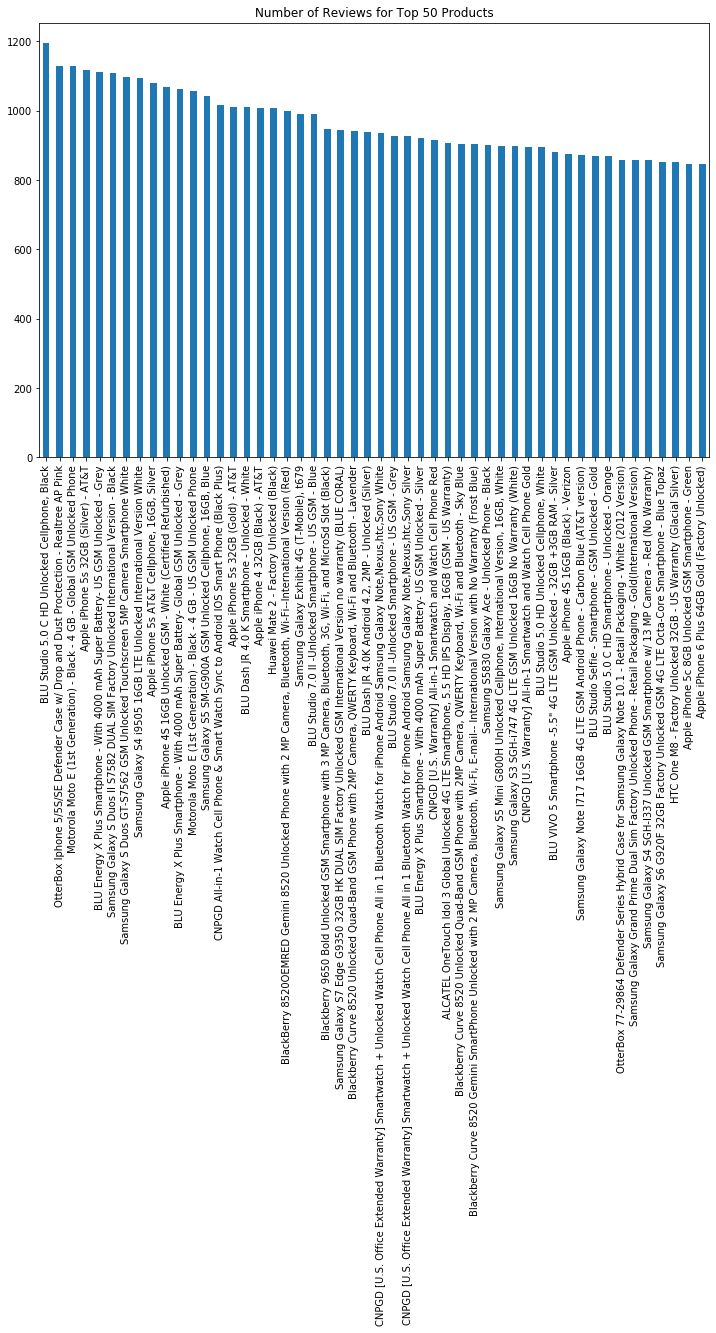

In [10]:
# Plot number of reviews for top 50 products
products = data["Product Name"].value_counts()
plt.figure(figsize=(12,8))
products[:50].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")

Text(0, 0.5, 'Count')

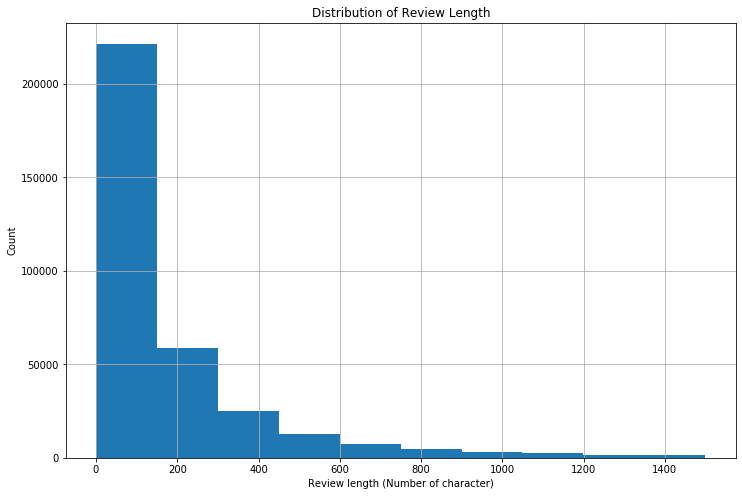

In [11]:
# Plot distribution of review length
review_length = data["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

In [12]:
#split data into training and testing set
x_train, x_test, y_train, y_test = train_test_split(data['Reviews'], data['Label'], test_size=0.1, random_state=0)


#If the label are words instead of numbers, they can be replaced programmatically using following two lines
# y_train = label_binarize(y_train, classes=[0, 1, 2])
# y_test = label_binarize(y_test, classes=[0, 1, 2])

In [13]:
# Preprocess text data in training set and validation set
x_train_cleaned = []
x_test_cleaned = []

for d in x_train:
    x_train_cleaned.append(cleanText(d))

for d in x_test:
    x_test_cleaned.append(cleanText(d))    

/usr/lib/python3/dist-packages/bs4/__init__.py:282: UserWarning: "http://www.amazon.com/gp/product/B00OSTKZWM?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_1" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/lib/python3/dist-packages/bs4/__init__.py:282: UserWarning: "http://www.amazon.com/gp/product/B013YDFH3Y?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/lib/python3/dist-packages/bs4/__init__.py:282: UserWarning: "https://www.amazon.com/gp/product/B00U8KSNB0/ref=cm_cr_ryp_prd_ttl_sol_22" looks like a URL. Beautiful Soup is not an HTTP client. You should 

### CountVectorizer with Mulinomial Naive Bayes (Benchmark Model)

Now we have cleaned reviews, the next step is to convert the reviews into numerical representations for machine learning algorithm.

In sklearn library, we can use CountVectorizer which implements both tokenization and occurrence counting in a single class. The output is a sparse matrix representation of a document.


The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [14]:
# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
x_train_countVect = countVect.fit_transform(x_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])

Number of features : 54166 

Show some feature names : 
 ['aa', 'aerial', 'andcamera', 'ascetics', 'baggies', 'birdwatching', 'broadcasters', 'cannoy', 'cherished', 'commend', 'consumo', 'crunched', 'deficient', 'diffcult', 'dong', 'electing', 'esper', 'expirience', 'finecamera', 'friendlier', 'girls', 'guessedit', 'hhi', 'ilemming', 'instagraming', 'iwhatever', 'lablel', 'literallyhave', 'maneuverable', 'microsost', 'movillnet', 'nicelooking', 'office', 'outreach', 'percentbecause', 'pla', 'prepain', 'providing', 'raving', 'regale', 'restoration', 'salgan', 'semipro', 'simscroll', 'solidarity', 'starr', 'superglue', 'telefonical', 'tidy', 'tricks', 'uninstallation', 'vampire', 'wapencmms', 'withxxex', 'yupp']


In [15]:
# Train MultinomialNB classifier
mnb = MultinomialNB()
%time mnb.fit(x_train_countVect, y_train)

CPU times: user 3.74 s, sys: 27.6 ms, total: 3.77 s
Wall time: 3.76 s


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [16]:
# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(x_test_cleaned))


In [17]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, predictions)

0.8552436794287539

In [18]:
# clf.fit(X_train,y_train)
# clf.score(X_test,y_test)
# y_pred = clf.predict(X_test)

In [19]:
#Save model for later use
naive_bayes_sentiment = 'naive_byes_sentiment.pkl'
dump(mnb, naive_bayes_sentiment)


['naive_byes_sentiment.pkl']

### TfidfVectorizer with Logistic Regression

Some words might frequently appear but have little meaningful information about the sentiment of a particular review. Instead of using occurance counting, we can use tf-idf transform to scale down the impact of frequently appeared words in a given corpus.

In sklearn library, we can use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [20]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
x_train_tfidf = tfidf.fit_transform(x_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(x_train_tfidf, y_train)

Number of features : 21131 

Show some feature names : 
 ['00', '9100', 'appearence', 'blinding', 'choked', 'cracked', 'directo', 'eq', 'floored', 'guidebook', 'indiscernible', 'leads', 'miami', 'occupied', 'pig', 'quedo', 'reviewedblackberry', 'shutting', 'studies', 'tmob', 'varies', 'youll']


/home/curiousgirl/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print("Total number of features = " + str(len(sorted_coef_index)))
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Total number of features = 21131

Top 10 features with smallest coefficients :
['great' 'love' 'amazing' 'excellent' 'perfect' 'perfectly' 'loves'
 'awesome' 'far' 'easy']

Top 10 features with largest coefficients : 
['worst' 'junk' 'not' 'useless' 'waste' 'unusable' 'garbage' 'worthless'
 'dissatisfied' 'horrible']


In [22]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(x_test_cleaned))
metrics.accuracy_score(y_test, predictions)

0.8840672259150678

### SVM and Trees

system will use two algorithms SVM and Random Forest to perform analysis and to determine which suits better for recommendation.

### Support Vector Machine

Here we implement multi-svm for sentiment analysis. More information about it can be found on [this](http://scikit-learn.org/stable/modules/svm.html) link. <br>

- Tip 1 : Here, different kernels can be tried out. For example, linear, nonlinear, precomputed, rbf etc.
- Tip 2 : The parameter values given below can be tweaked to obtain different results.

### Using LinearSVC

Here you can tweak the api parameters of LinearSVC as per your choice. Refer to [this](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) link for making any changes.

In [23]:
zipx_train_subset = tfidf.transform(x_train_cleaned[:100])
x_train_input = tfidf.transform(x_train_cleaned)
svr_lin = LinearSVC(multi_class='ovr',C=1.0,loss='squared_hinge', dual=False)
svr_lin.fit(x_train_input, y_train)
y_svr_lin_predicted = svr_lin.predict(tfidf.transform(x_test_cleaned))

In [24]:
metrics.accuracy_score(y_svr_lin_predicted, y_test)

0.8916432033903224

### Functions for Model Evaluation

There are multiple functions for model evaluation in scikit learn. To know more about them, please follow the below mentioned links
- [accuracy score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
- [f_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)
- [f1_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)
- [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

In [25]:
print("Accuracy of this SVM = " + str(metrics.accuracy_score(y_test, y_svr_lin_predicted)))
print("Fscore of this SVM = " + str(metrics.precision_recall_fscore_support(y_test, y_svr_lin_predicted, pos_label=2, average='weighted')))
print("F-1 score of this SVM = " + str(metrics.f1_score(y_test, y_svr_lin_predicted, pos_label=2, average='weighted')))
print("confusion matrix = " + str(metrics.confusion_matrix(y_test, y_svr_lin_predicted)))

Accuracy of this SVM = 0.8916432033903224


/home/curiousgirl/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 2) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Fscore of this SVM = (0.883388648009047, 0.8916432033903224, 0.8771689786210045, None)
F-1 score of this SVM = 0.8771689786210045
confusion matrix = [[ 7218   112   808]
 [  850   674  1212]
 [  621   130 22826]]


In [26]:
#Save model for later use
modelName = 'sentiment_analysis.pkl'
dump(svr_lin, modelName)


['sentiment_analysis.pkl']